In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from glob import glob
from tqdm.contrib.concurrent import process_map
%matplotlib inline

In [13]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble']=(
    r'\usepackage{amsmath}'
    r'\usepackage[bitstream-charter]{mathdesign}'
)

In [2]:
# DATA_DIR = '/scratch2/heneka/21cmlightcones/pure_simulations'
DATA_DIR = '/remote/gpu01a/heneka/21cmlightcones/pure_simulations'

files = glob(f'{DATA_DIR}/*.npz')

In [6]:
SHAPE = [140, 140, 2350]
RESHAPE_2 = [r for s in SHAPE for r in [s//2, 2]]
RESHAPE_5 = [r for s in SHAPE for r in [s//5, 5]]

In [8]:
x = np.load(files[0])['image']
y2 = np.mean(x.reshape(*RESHAPE_2), axis=(1, 3, 5))
y5 = np.mean(x.reshape(*RESHAPE_5), axis=(1, 3, 5))    

In [9]:
def compare_resolutions(idx):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    
    ax[0].imshow(x[:, :, idx])
    ax[1].imshow(y2[:, :, idx//2])
    ax[2].imshow(y5[:, :, idx//5])

    ax[0].set_title('Original')
    ax[1].set_title('x2')
    ax[2].set_title('x5')

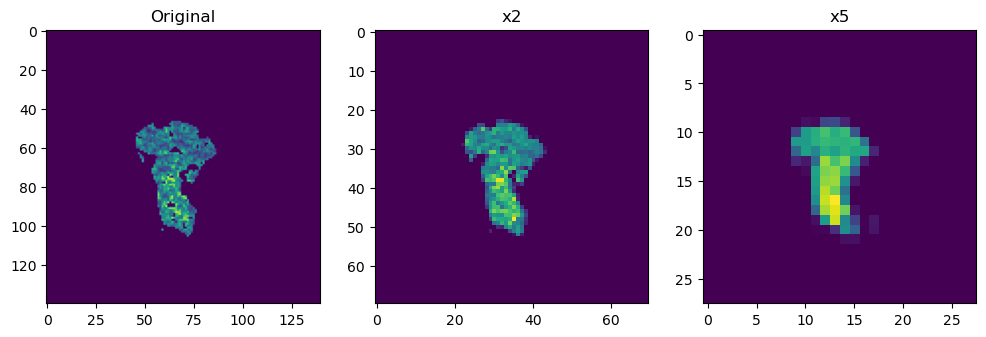

In [12]:
compare_resolutions(1000)

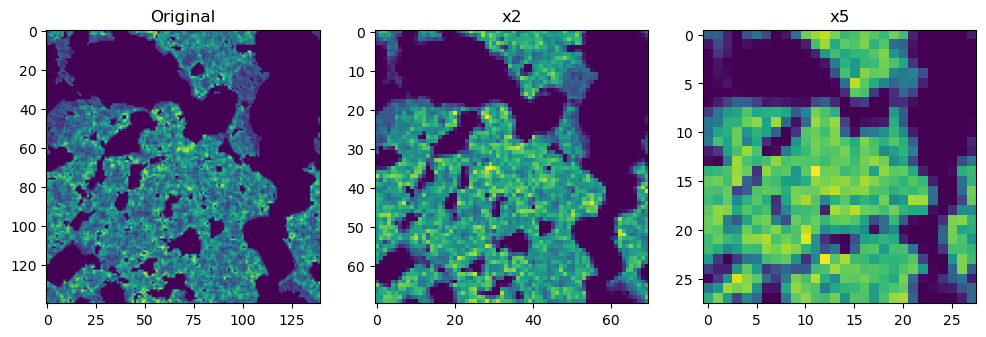

In [118]:
compare_resolutions(1200)

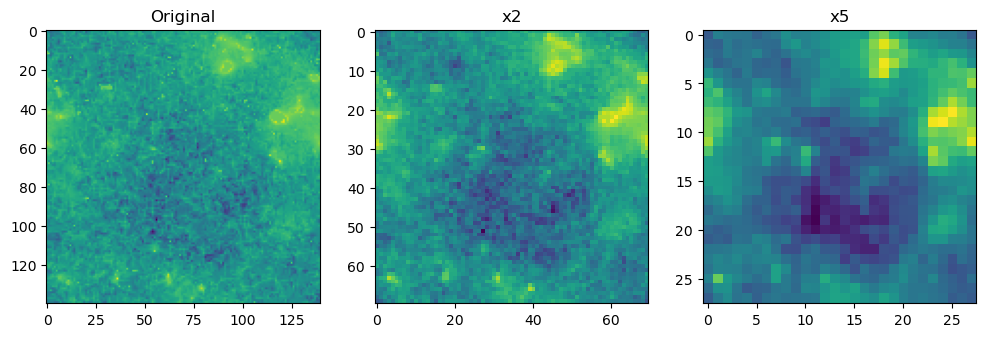

In [119]:
compare_resolutions(2000)

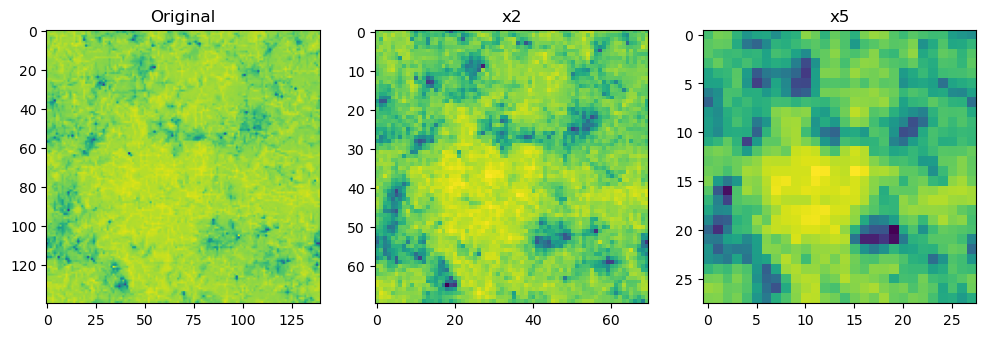

In [120]:
compare_resolutions(-1)

## Upsampled downsampled lightcone

In [28]:
dirs = {
    'x2': '/remote/gpu01a/heneka/21cmlightcones/pure_simulations/x2',
    'x5': '/remote/gpu01a/heneka/21cmlightcones/pure_simulations/x5',
    'x5to2': '/remote/gpu01a/heneka/21cmlightcones/pure_simulations/x5to2'
}

In [29]:
run = 1
lcs = {k: np.load(d + f'/run{run}.npz')['image'] for k,d in dirs.items()}

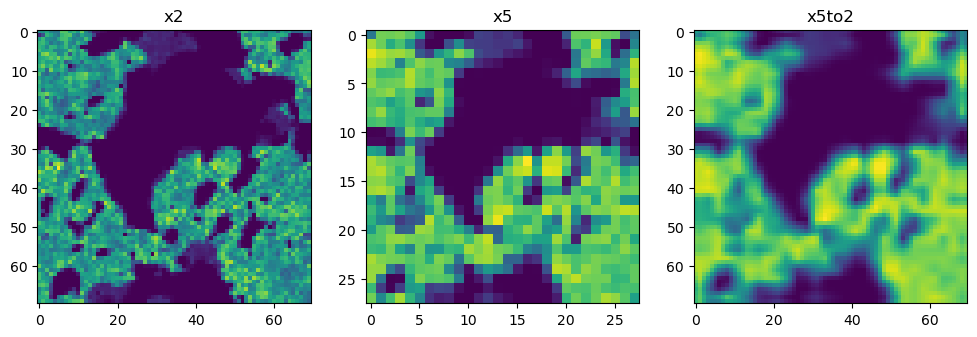

In [30]:
idx = 1200
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for i, (k, x) in enumerate(lcs.items()):
    ax[i].imshow(x[:, :, idx//int(k[-1])])
    ax[i].set_title(k)
plt.show()

## Masked lightcones

In [62]:
import math
import torch
from einops import rearrange, repeat

In [178]:
MASK_FRAC = 0.4
PATCH_SHAPE = [2, 2, 10]
LC_SHAPE = [28, 28, 470]
NUM_PATCHES = [s//p for p, s in zip(PATCH_SHAPE, LC_SHAPE)]
def to_patches(x):
    x = rearrange(
        x, '(x p1) (y p2) (z p3) -> (x y z) (p1 p2 p3)',
        **dict(zip(('p1', 'p2', 'p3'), PATCH_SHAPE))
    )
    return x

def from_patches(x):
    x = rearrange(
        x, '(x y z) (p1 p2 p3) -> (x p1) (y p2) (z p3)',
        **dict(zip(('x', 'y', 'z', 'p1', 'p2', 'p3'), NUM_PATCHES+PATCH_SHAPE))
    )
    return x

def random_mask_block_patches(x):
    """
    Masks x by randomly selecting a block of patches in each batch (currently 
    same for all batches) and replacing their embedding with `self.mask_token`. 
    The number of patches to mask is determined by the `self.cfg.mask_frac` option.
    TODO: individual mask for every batch
    """
    T = x.size(0)
    mask_token = torch.full([math.prod(PATCH_SHAPE)], x.max())
    full_mask = repeat(mask_token, 'd -> t d', t=T)
    mask_idcs = sample_block_indcs()
    mask_map = torch.zeros(T).scatter_(-1, mask_idcs, 1).bool()
    return torch.where(mask_map[..., None], full_mask, x)

def sample_block_indcs():
    """
    Helper that samples block mask indices
    TODO: test that it correctly samples blocks shapes
    """
    height, width, depth = NUM_PATCHES
    h, w, d = sample_block_size()

    # Sample block top-left corner
    top = torch.randint(0, height - h + 1, (1,))
    left = torch.randint(0, width - w + 1, (1,))
    back = torch.randint(0, depth - d + 1, (1,))
    mask_idcs = torch.zeros((height, width, depth), dtype=torch.int32)
    mask_idcs[top:top+h, left:left+w, back:back+d] = 1
    mask_idcs = torch.nonzero(mask_idcs.flatten())
    return mask_idcs.squeeze(1)
    
def sample_block_size():
    """
    Helper that samples block mask dimensions
    TODO: random aspect ratio, variable size
    """
    h, _, d = NUM_PATCHES
    h *= (MASK_FRAC)** (1. / 3)
    d *= (MASK_FRAC)** (1. / 3)
    return (int(h + .5), int(h + .5), int(d + .5))

In [179]:
lc = np.load('/remote/gpu02/ore/data/x5/run53.npz')['image']
lc_patches = to_patches(torch.from_numpy(lc))
masked_patches = random_mask_block_patches(lc_patches)
masked_lc = from_patches(masked_patches)

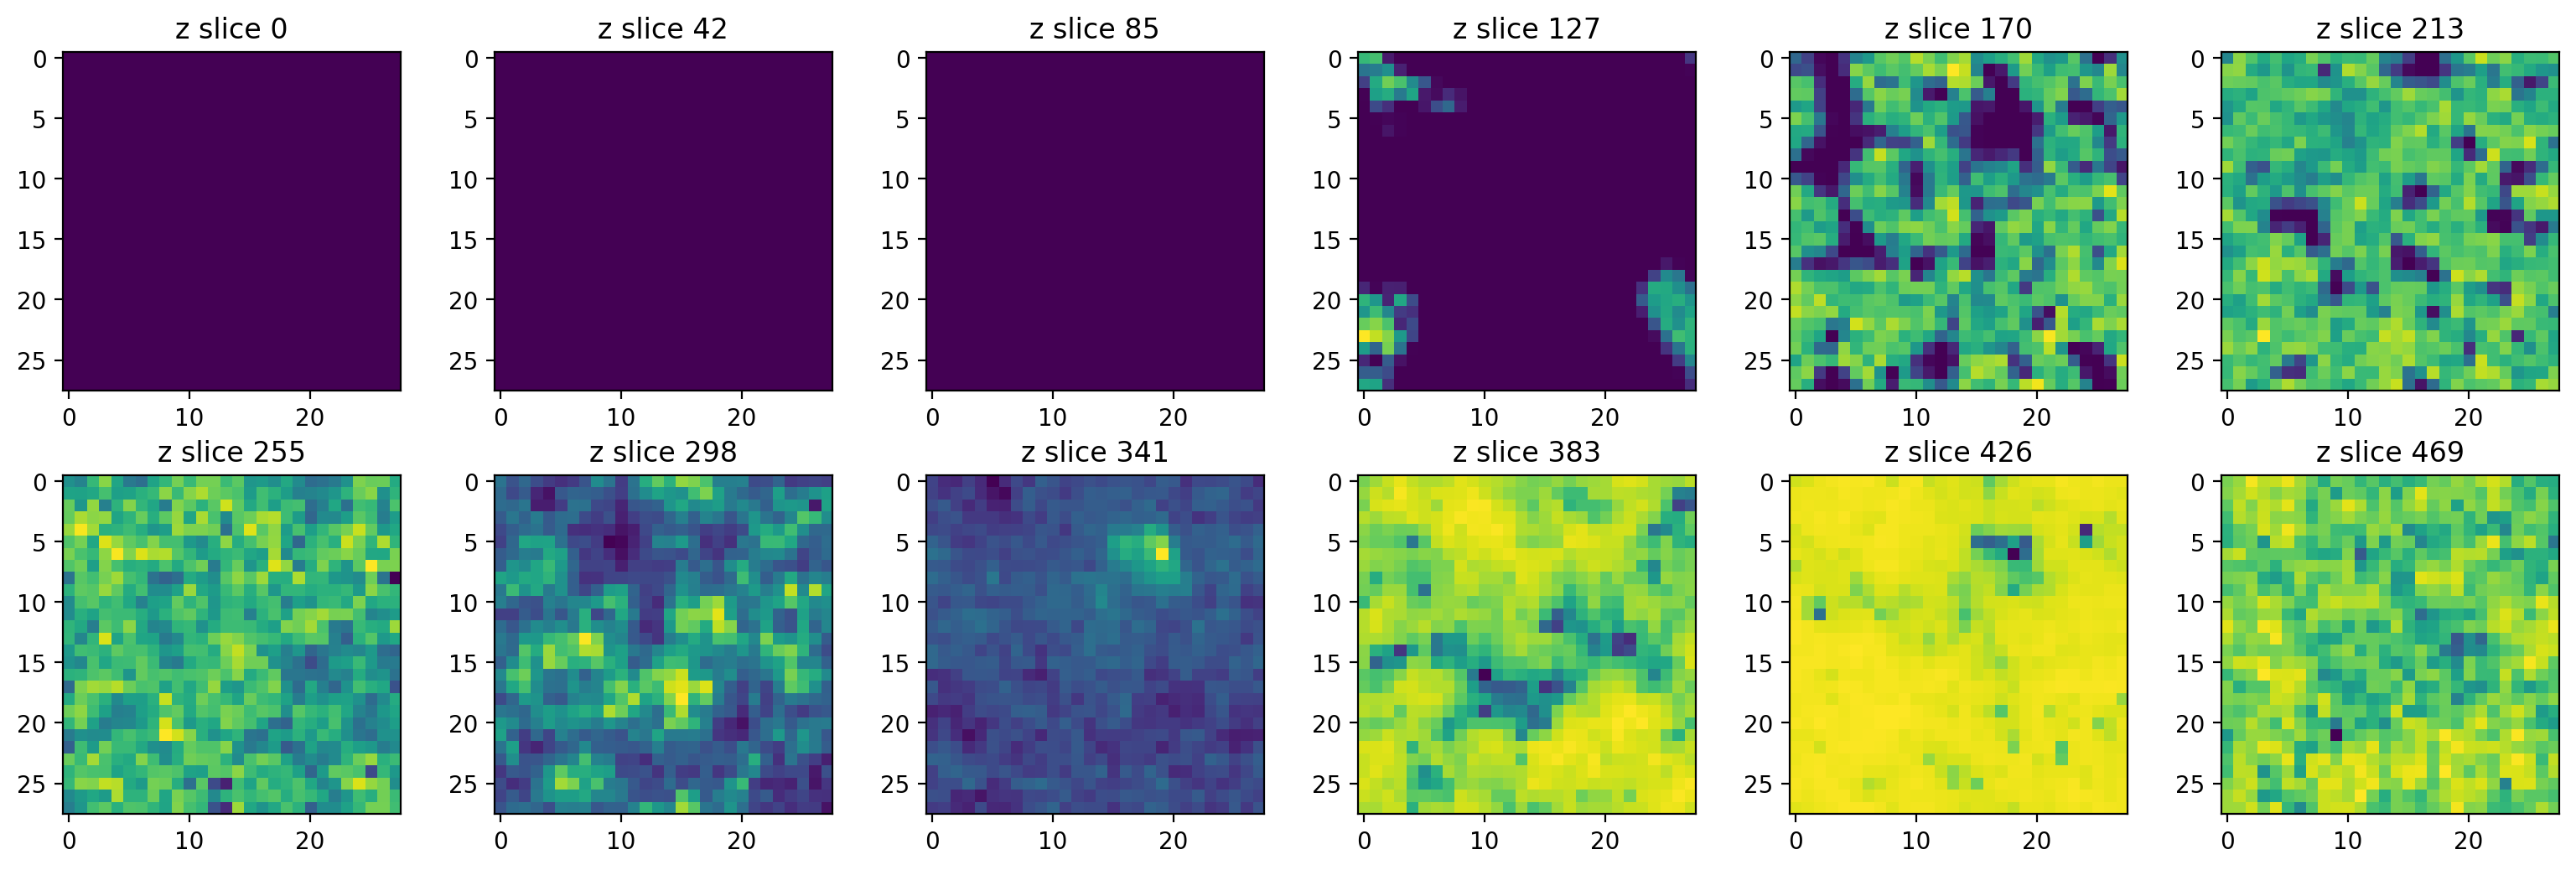

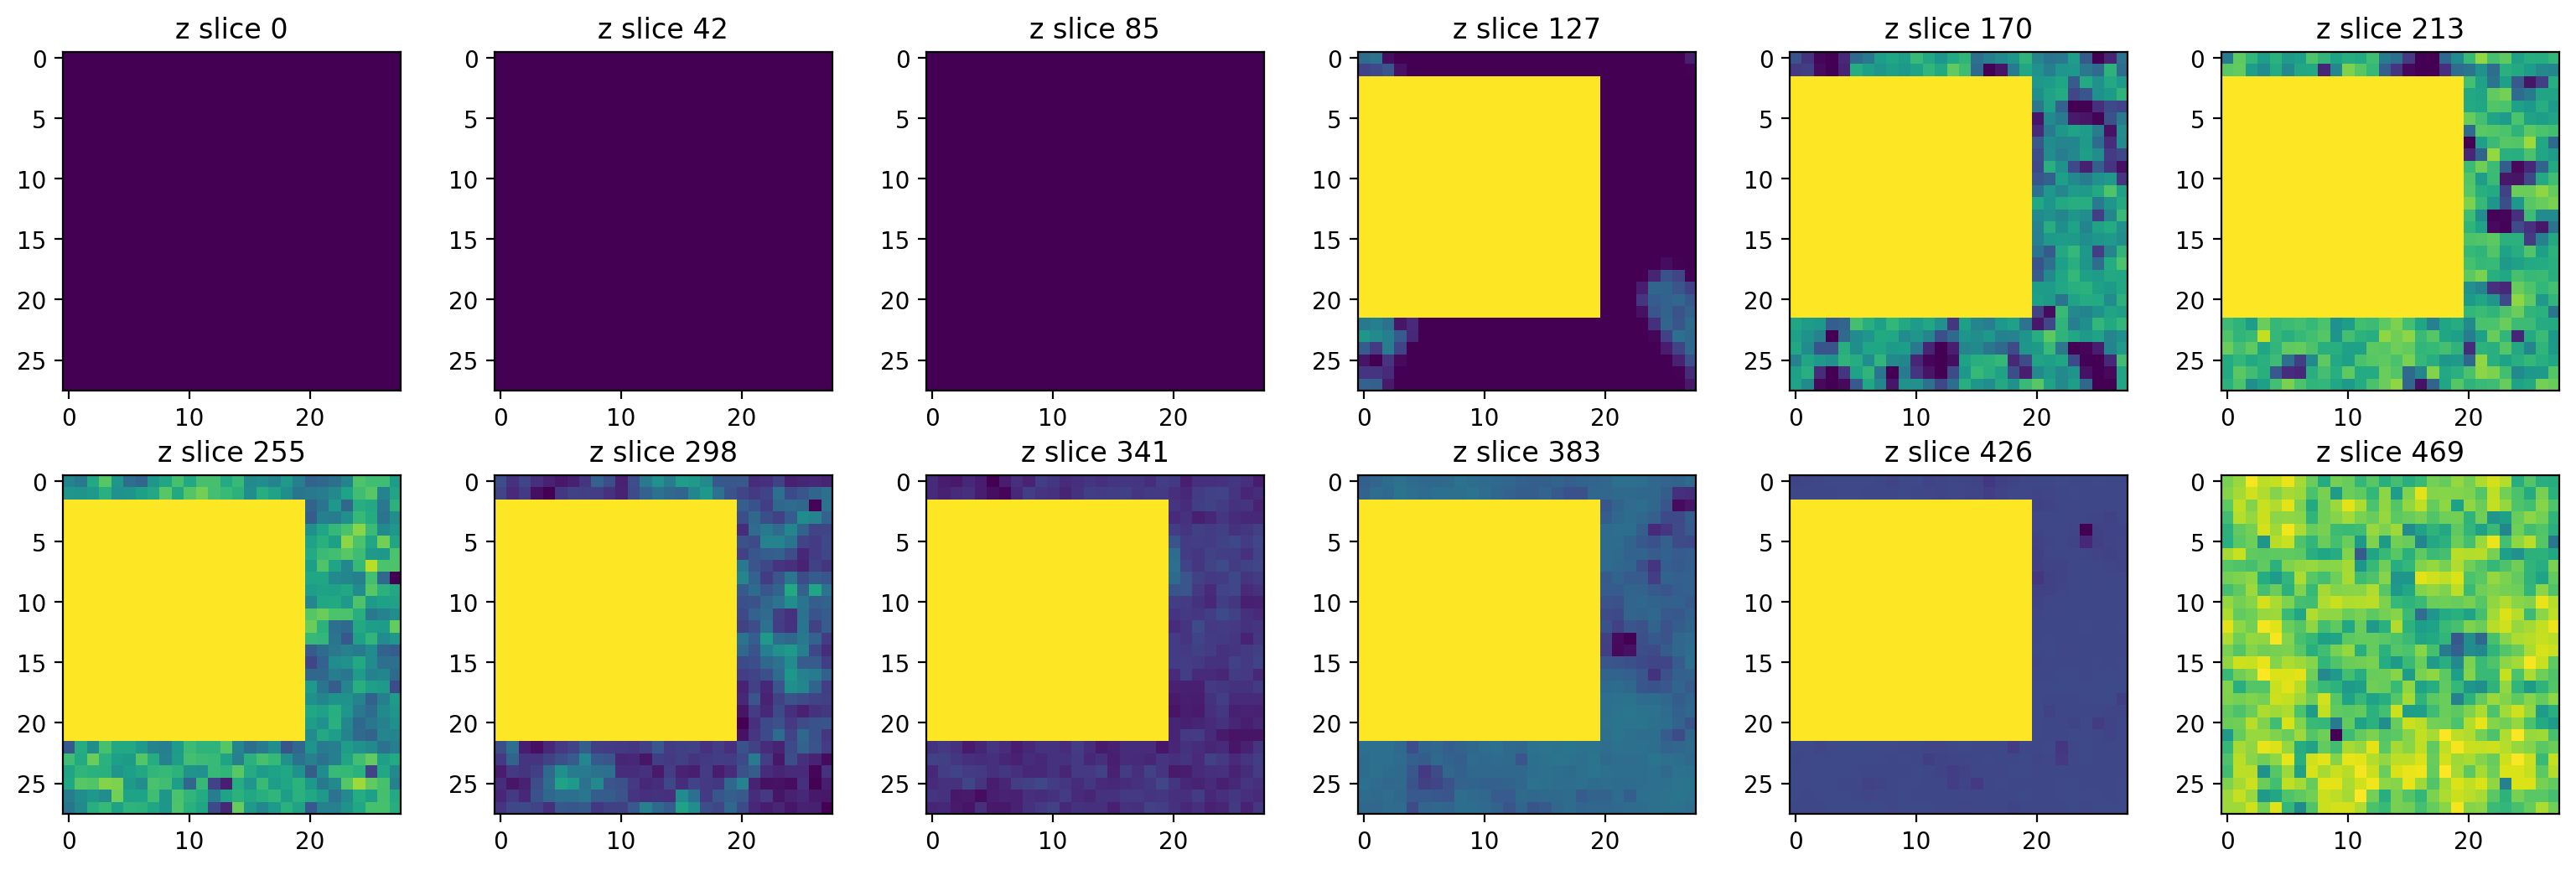

In [180]:
num_slices = 12
fig, ax = plt.subplots(2, num_slices//2, figsize=(num_slices*1.3, 4*1.3), dpi=200)
for i, idx in enumerate(np.linspace(0, lc.shape[2]-1, num_slices)):
    ax[i//6, i%6].imshow(lc[:, :, int(idx)])
    ax[i//6, i%6].set_title(f'z slice {int(idx)}')
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(2, num_slices//2, figsize=(num_slices*1.3, 4*1.3), dpi=200)
for i, idx in enumerate(np.linspace(0, lc.shape[2]-1, num_slices)):
    ax[i//6, i%6].imshow(masked_lc[:, :, int(idx)])
    ax[i//6, i%6].set_title(f'z slice {int(idx)}')
plt.tight_layout()
plt.show()